In [25]:
import keras
from keras.datasets import imdb # new!
from keras.preprocessing.sequence import pad_sequences #new!
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Embedding # new!
from keras.callbacks import ModelCheckpoint # new!
import os # new!
from sklearn.metrics import roc_auc_score, roc_curve # new!
import pandas as pd
import matplotlib.pyplot as plt # new!
%matplotlib inline


## Hyperparams & Loading Data

In [26]:
# output directory name:
output_dir = 'model_output/dense'

# training:
epochs = 4 # nlp costuma overfittar in fewer epochs
batch_size = 128

# vector-space embedding:
n_dim = 64
n_unique_words = 5000 # may not be optimal
n_words_to_skip = 50
max_review_length = 100 # for tensorflow recognization
pad_type = trunc_type = 'pre' # padding for <100 reviews
#padding at the start of reviews
# trunc removes word at the beginning assuming end of film reviews
# include more info or review sentiment

# neural network architecture:
n_dense = 64 # neurons
dropout = 0.5


In [27]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words, # max unique tokens
               skip_top=n_words_to_skip)


■ Reviews with a score of four stars or fewer are considered to be a negative review
(y = 0).

■ Reviews with a score of seven stars or more, meanwhile, are classed as a positive
review (y = 1).

■ Moderate reviews—those with five or six stars—are not included in the dataset,
making the binary classification task easier for any model.

### Examining Data

In [28]:
x_train[0:6] # 0 reserved for padding; 1 would be starting character;
# 2 is unknown; 3 is most common word, etc.

array([list([2, 2, 2, 2, 2, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 2, 173, 2, 256, 2, 2, 100, 2, 838, 112, 50, 670, 2, 2, 2, 480, 284, 2, 150, 2, 172, 112, 167, 2, 336, 385, 2, 2, 172, 4536, 1111, 2, 546, 2, 2, 447, 2, 192, 50, 2, 2, 147, 2025, 2, 2, 2, 2, 1920, 4613, 469, 2, 2, 71, 87, 2, 2, 2, 530, 2, 76, 2, 2, 1247, 2, 2, 2, 515, 2, 2, 2, 626, 2, 2, 2, 62, 386, 2, 2, 316, 2, 106, 2, 2, 2223, 2, 2, 480, 66, 3785, 2, 2, 130, 2, 2, 2, 619, 2, 2, 124, 51, 2, 135, 2, 2, 1415, 2, 2, 2, 2, 215, 2, 77, 52, 2, 2, 407, 2, 82, 2, 2, 2, 107, 117, 2, 2, 256, 2, 2, 2, 3766, 2, 723, 2, 71, 2, 530, 476, 2, 400, 317, 2, 2, 2, 2, 1029, 2, 104, 88, 2, 381, 2, 297, 98, 2, 2071, 56, 2, 141, 2, 194, 2, 2, 2, 226, 2, 2, 134, 476, 2, 480, 2, 144, 2, 2, 2, 51, 2, 2, 224, 92, 2, 104, 2, 226, 65, 2, 2, 1334, 88, 2, 2, 283, 2, 2, 4472, 113, 103, 2, 2, 2, 2, 2, 178, 2]),
       list([2, 194, 1153, 194, 2, 78, 228, 2, 2, 1463, 4369, 2, 134, 2, 2, 715, 2, 118, 1634, 2, 394, 2, 2, 119, 954, 189, 102, 2, 20

In [29]:
for x in x_train[0:6]:
  print(len(x))

218
189
141
550
147
43


Restoring words from index

In [30]:
word_index = keras.datasets.imdb.get_word_index()
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["PAD"] = 0
word_index["START"] = 1
word_index["UNK"] = 2


In [31]:
index_word = {v:k for k,v in word_index.items()}

In [32]:
' '.join(index_word[id] for id in x_train[0])

"UNK UNK UNK UNK UNK brilliant casting location scenery story direction everyone's really suited UNK part UNK played UNK UNK could UNK imagine being there robert UNK UNK UNK amazing actor UNK now UNK same being director UNK father came UNK UNK same scottish island UNK myself UNK UNK loved UNK fact there UNK UNK real connection UNK UNK UNK UNK witty remarks throughout UNK UNK were great UNK UNK UNK brilliant UNK much UNK UNK bought UNK UNK UNK soon UNK UNK UNK released UNK UNK UNK would recommend UNK UNK everyone UNK watch UNK UNK fly UNK UNK amazing really cried UNK UNK end UNK UNK UNK sad UNK UNK know what UNK say UNK UNK cry UNK UNK UNK UNK must UNK been good UNK UNK definitely UNK also UNK UNK UNK two little UNK UNK played UNK UNK UNK norman UNK paul UNK were UNK brilliant children UNK often left UNK UNK UNK UNK list UNK think because UNK stars UNK play them UNK grown up UNK such UNK big UNK UNK UNK whole UNK UNK these children UNK amazing UNK should UNK UNK UNK what UNK UNK done do

In [33]:
word_index

{'fawn': 34704,
 'tsukino': 52009,
 'nunnery': 52010,
 'sonja': 16819,
 'vani': 63954,
 'woods': 1411,
 'spiders': 16118,
 'hanging': 2348,
 'woody': 2292,
 'trawling': 52011,
 "hold's": 52012,
 'comically': 11310,
 'localized': 40833,
 'disobeying': 30571,
 "'royale": 52013,
 "harpo's": 40834,
 'canet': 52014,
 'aileen': 19316,
 'acurately': 52015,
 "diplomat's": 52016,
 'rickman': 25245,
 'arranged': 6749,
 'rumbustious': 52017,
 'familiarness': 52018,
 "spider'": 52019,
 'hahahah': 68807,
 "wood'": 52020,
 'transvestism': 40836,
 "hangin'": 34705,
 'bringing': 2341,
 'seamier': 40837,
 'wooded': 34706,
 'bravora': 52021,
 'grueling': 16820,
 'wooden': 1639,
 'wednesday': 16821,
 "'prix": 52022,
 'altagracia': 34707,
 'circuitry': 52023,
 'crotch': 11588,
 'busybody': 57769,
 "tart'n'tangy": 52024,
 'burgade': 14132,
 'thrace': 52026,
 "tom's": 11041,
 'snuggles': 52028,
 'francesco': 29117,
 'complainers': 52030,
 'templarios': 52128,
 '272': 40838,
 '273': 52031,
 'zaniacs': 52133,

In [34]:
(all_x_train,_),(all_x_valid,_) = imdb.load_data()

In [35]:
' '.join(index_word[id] for id in all_x_train[0])

"START this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and shou

## Preprocess

In [36]:
x_train = pad_sequences(x_train, maxlen=max_review_length,
                        padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length,
                        padding=pad_type, truncating=trunc_type, value=0)

In [37]:
x_train[0:6]

array([[1415,    2,    2,    2,    2,  215,    2,   77,   52,    2,    2,
         407,    2,   82,    2,    2,    2,  107,  117,    2,    2,  256,
           2,    2,    2, 3766,    2,  723,    2,   71,    2,  530,  476,
           2,  400,  317,    2,    2,    2,    2, 1029,    2,  104,   88,
           2,  381,    2,  297,   98,    2, 2071,   56,    2,  141,    2,
         194,    2,    2,    2,  226,    2,    2,  134,  476,    2,  480,
           2,  144,    2,    2,    2,   51,    2,    2,  224,   92,    2,
         104,    2,  226,   65,    2,    2, 1334,   88,    2,    2,  283,
           2,    2, 4472,  113,  103,    2,    2,    2,    2,    2,  178,
           2],
       [ 163,    2, 3215,    2,    2, 1153,    2,  194,  775,    2,    2,
           2,  349, 2637,  148,  605,    2,    2,    2,  123,  125,   68,
           2,    2,    2,  349,  165, 4362,   98,    2,    2,  228,    2,
           2,    2, 1157,    2,  299,  120,    2,  120,  174,    2,  220,
         175,  136,   5

In [38]:
for x in x_train[0:6]:
    print(len(x))


100
100
100
100
100
100


In [39]:
' '.join(index_word[id] for id in x_train[0])


"cry UNK UNK UNK UNK must UNK been good UNK UNK definitely UNK also UNK UNK UNK two little UNK UNK played UNK UNK UNK norman UNK paul UNK were UNK brilliant children UNK often left UNK UNK UNK UNK list UNK think because UNK stars UNK play them UNK grown up UNK such UNK big UNK UNK UNK whole UNK UNK these children UNK amazing UNK should UNK UNK UNK what UNK UNK done don't UNK think UNK whole story UNK UNK lovely because UNK UNK true UNK UNK someone's life after UNK UNK UNK UNK UNK us UNK"

In [40]:
' '.join(index_word[id] for id in x_train[5])


'PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD UNK begins better than UNK ends funny UNK UNK russian UNK crew UNK UNK other actors UNK UNK those scenes where documentary shots UNK UNK spoiler part UNK message UNK UNK contrary UNK UNK whole story UNK UNK does UNK UNK UNK UNK'

## Neural Network Architecture

In [41]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, # create word vectors from a corpus of documents
                    input_length=max_review_length))
# size of vector = n unique words
model.add(Flatten()) # transformou em 1 dimension

model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))
# model.add(Dense(n_dense, activation='relu'))
# model.add(Dropout(dropout))

model.add(Dense(1, activation='sigmoid')) # output probaBilistico

In [43]:
model.build(input_shape=(None, max_review_length))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 64)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       409,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 729,729 (2.78 MB)

 Trainable params: 729,729 (2.78 MB)

 Non-trainable params: 0 (0.00 B)

■ In the embedding layer, the 320,000 parameters come from having 5,000 words,
each one with a location specified in a 64-dimensional word-vector space
(64 × 5,000 = 320,000).

■ Flowing out of the embedding layer through the flatten layer and into the dense
layer are 6,400 values: Each of our film-review inputs consists of 100 tokens, with
each token specified by 64 word-vector-space coordinates (64 × 100 = 6,400).

■ Each of the 64 neurons in the dense hidden layer receives input from each of the
6,400 values flowing out of the flatten layer, for a total of 64 × 6,400 = 409,600

In [44]:
model.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=['accuracy'])

In [46]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+
                                  "/weights.{epoch:02d}.keras")

if not os.path.exists(output_dir):
  os.makedirs(output_dir)

In [47]:
model.fit(x_train, y_train,
          batch_size=batch_size, epochs=epochs, verbose=1,
          validation_data=(x_valid, y_valid),
          callbacks=[modelcheckpoint])


Epoch 1/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.5861 - loss: 0.6470 - val_accuracy: 0.8340 - val_loss: 0.3720
Epoch 2/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.8724 - loss: 0.3055 - val_accuracy: 0.8488 - val_loss: 0.3433
Epoch 3/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.9561 - loss: 0.1370 - val_accuracy: 0.8331 - val_loss: 0.4192
Epoch 4/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.9954 - loss: 0.0319 - val_accuracy: 0.8340 - val_loss: 0.5161


In [48]:
model.load_weights(output_dir+"/weights.02.keras")

In [50]:
y_hat = model.predict(x_valid)

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


In [54]:
len(y_hat)

25000

In [53]:
y_hat[0], y_valid[0]

(array([0.10406265], dtype=float32), np.int64(0))

In [55]:
# full validation review
' '.join(index_word[id] for id in all_x_valid[0])

"START please give this one a miss br br kristy swanson and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite lacklustre so all you madison fans give this a miss"

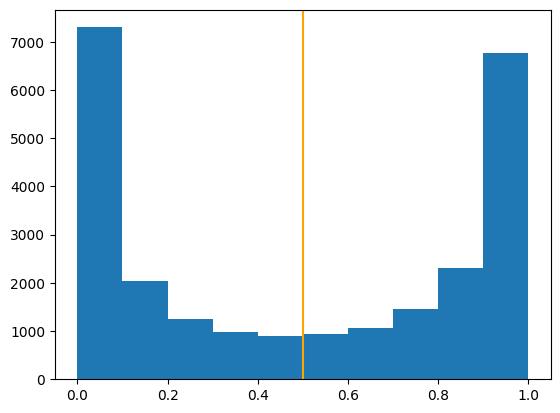

In [56]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')
# linha orange marca o 0.5 threshold

Calculating ROC AUC for validation data

In [58]:
pct_auc = roc_auc_score(y_valid, y_hat)*100.0
"{:0.2f}".format(pct_auc)

'92.82'

Dataframe de y e yhat

In [60]:
float_y_hat = []
for y in y_hat:
  float_y_hat.append(y[0])

ydf = pd.DataFrame(list(zip(float_y_hat, y_valid)),
columns=['y_hat', 'y'])

In [61]:
ydf.head(10)

,y_hat,y
0,0.104063,0
1,0.933620,1
2,0.846026,1
3,0.559863,0
4,0.994287,1
5,0.620423,1
6,0.812814,1
7,0.013390,0
8,0.933077,0
9,0.713008,1


In [62]:
ydf[(ydf.y == 0) & (ydf.y_hat > 0.9)].head(10)
# negative validation reviews com valores previstos altos
# falsos positivos

,y_hat,y
8,0.933077,0
75,0.920934,0
152,0.952704,0
386,0.958666,0
547,0.960020,0
555,0.941291,0
680,0.912601,0
693,0.923393,0
740,0.985050,0
778,0.916193,0


In [66]:
ydf[(ydf.y == 1) & (ydf.y_hat < 0.45)].head(10)
# falsos negativo

,y_hat,y
45,0.171883,1
49,0.416511,1
72,0.321311,1
80,0.287390,1
83,0.303886,1
93,0.322808,1
100,0.203284,1
101,0.039216,1
126,0.295017,1
146,0.320135,1


The  dense classifier is
not specialized to detect patterns of multiple tokens occurring in a sequence that might
predict film-review sentiment.